In [26]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as st
# import scipy.linalg as linalg
# import scipy.optimize as so
# import statsmodels.api as sm
# import statsmodels.graphics.tsaplots as sm 
import random
# import time
import math
from sklearn.linear_model import LinearRegression


# import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from numpy import matlib
# from scipy import io
# from scipy.special import erf
# from scipy.fftpack import fft, ifft
# from scipy import interpolate as intrp
# from matplotlib import rc
# from tools import *

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Point 1 - Basic ABC rejection algorithm

In [27]:
def discrepancy_metric(x, sample_mean=0):
    # rho(S(D*),S(D)) = abs(mean(x*) - mean(x)), we assume that mean(x)=0 (sample mean)
    return abs(np.mean(x) - sample_mean)

def true_mixture_distribution(x, M, a, var, var_1, sample_mean=0):
    alfa = 1./( 1 + np.exp( a * (sample_mean - 0.5*a) * M / (M*var + var_1) ) )
    pdf_1 = alfa * st.norm.pdf(x=x, loc = var/(var+var_1/M)*sample_mean, scale = np.sqrt(var_1/(M+var_1/var)))
    pdf_2 = (1-alfa) * st.norm.pdf(x=x, loc = var/(var+var_1/M)*(sample_mean-a), scale = np.sqrt(var_1/(M+var_1/var)))
    # f = alfa * st.norm(loc = var/(var+var_1/M)*sample_mean, scale = var_1/(M+var_1/var)) + (1-alfa) * st.norm(loc = var/(var+var_1/M)*(sample_mean-a), scale = var_1/(M+var_1/var))
    f = pdf_1 + pdf_2
    return f

def generate_data(M, theta, var, var_1, a):
    D = np.zeros(M)
    # do stuff ...
    return D

def basic_abc(N, M, eps, var, var_1, a):
    theta = np.zeros(N) #at the end of the algorithm it has to be full (algorithm ends when we have selected N samples)
    pi_rv = st.norm(loc=0, scale=np.sqrt(var))
    rejection_count = 0
    n1_count = 0  #DEBUG
    n2_count = 0  #DEBUG
    i = 0 # count of the number of selected samples
    
    while i < N:
        # sample candidate parameters from the prior distribution pi = N(0,var)
        theta_star = pi_rv.rvs()
    
        # generate data from the underlying model given theta_star
        # D observed data, is an iid sample drawn with prob=0.5 from N(theta,var_1), o/w from N(theta+a,var_1)
        N1_rv = st.norm(loc=theta_star, scale=np.sqrt(var_1))
        N2_rv = st.norm(loc=theta_star + a, scale=np.sqrt(var_1))
        D = np.zeros(M)
        
        #build a set of M observation from the underlying model given theta_star
        if np.random.choice([0, 1]) == 0:
            for j in range(M):
                D[j] = N1_rv.rvs()
                n1_count += 1
        else:
            for j in range(M):
                D[j] = N2_rv.rvs()
                n2_count += 1
        
        if discrepancy_metric(D) < eps:
            theta[i] = theta_star
            i += 1 # a new sample is selected
        else:
            rejection_count += 1
    
    print('acceptance rate:', N/(N + rejection_count))
    return theta

In [28]:
# set problem parameters
M = 100
var_1 = 0.1
var = 3
a = 1
sample_mean = 0  # assumed to be exactly =0

eps = [0.75, 0.25, 0.1, 0.025]  # tolerances
N = 500  # max number of accepted samples

In [29]:
x_values = np.linspace(-1.25, 0.5, 500)
f = true_mixture_distribution(x_values, M, a, var, var_1, sample_mean=0)

theta_list = []

for e in eps:
    theta = basic_abc(N, M, e, var, var_1, a)
    theta_list.append(theta)

acceptance rate: 0.3190810465858328
acceptance rate: 0.11165698972755694
acceptance rate: 0.043044077134986224
acceptance rate: 0.010387020379333985


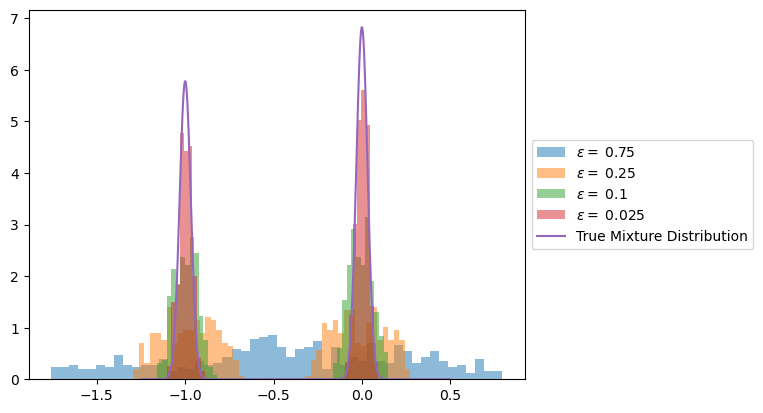

In [30]:
plt.figure()

for i in (range(len(eps))):
    plt.hist(theta_list[i], density=True, bins=50, alpha=0.5, label=r'$\epsilon =$ %s' % eps[i])
    
plt.plot(x_values, f, label='True Mixture Distribution')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

/Users/michelelupini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michelelupini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michelelupini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michelelupini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

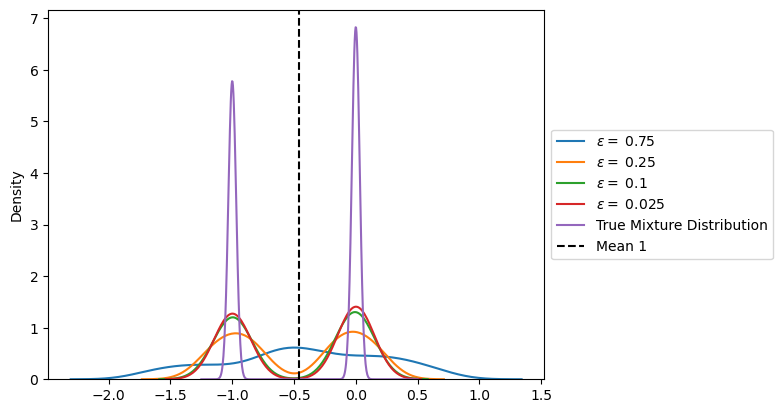

In [31]:
plt.figure()
alpha =  1./( 1 + np.exp( a * (sample_mean - 0.5*a) * M / (M*var + var_1) ) )

for i in (range(len(eps))):
    sns.kdeplot(theta_list[i], label=r'$\epsilon =$ %s' % eps[i])
    
plt.plot(x_values, f, label='True Mixture Distribution')
plt.axvline(x=0+(1-alpha)*var/(var+var_1/M)*(sample_mean-a), color='black', linestyle='--', label='Mean 1')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [32]:
sample_mean = 0

print("mu1 is:", var/(var+var_1/M)*sample_mean, ", sdt1 is:", np.sqrt(var_1/(M+var_1/var)))
print("mu2 is:", var/(var+var_1/M)*(sample_mean-a), ", std2 is:", np.sqrt(var_1/(M+var_1/var)))
print("alpha is:",alpha)

print("mean of true mixture distribution is:",(1-alpha)*var/(var+var_1/M)*(sample_mean-a))

mu1 is: 0.0 , sdt1 is: 0.03161750745616664
mu2 is: -0.9996667777407531 , std2 is: 0.03161750745616664
alpha is: 0.5415566948980146
mean of true mixture distribution is: -0.4582905415881227


# Point 3 - ABC-MCMC algorithm

## ver. 1.1 - effective sample size

In [33]:
def abc_mcmc(N_max, M, eps, nu_squared, var, var_1, a):
    theta = np.zeros(N_max+1)
    pi_rv = st.norm(loc=0, scale=np.sqrt(nu_squared))  # prior 
    
    acceptance_count = 0
    rejection_count = 0
    entered = 0
    i = 0
    metropoli_ratio_list = []
    
    while i < N_max:
        # sample candidate parameters from a proposal transition density q(theta_i, )
        # random walk proposal q(theta, ) = N(theta,nu_squared)
        q_i = st.norm(loc=theta[i], scale=nu_squared)
        theta_star = q_i.rvs()
    
        # generate data from the underlying model given theta_star
        # generate_data function: TODO
        N1_rv = st.norm(loc=theta_star, scale=np.sqrt(var_1))
        N2_rv = st.norm(loc=theta_star + a, scale=np.sqrt(var_1))
        
        D = np.zeros(M)
        if np.random.choice([0, 1]) == 0:
            for j in range(M):
                D[j] = N1_rv.rvs()
                # n1_count = n1_count + 1
        else:
            for j in range(M):
                D[j] = N2_rv.rvs()
                # n2_count = n1_count + 1
    
        if discrepancy_metric(D) < eps:
            q_star = st.norm(loc=theta_star, scale=np.sqrt(nu_squared))
            comp = pi_rv.pdf(theta_star)*q_star.pdf(theta[i])/( pi_rv.pdf(theta[i])*q_i.pdf(theta_star) )
            metropoli_ratio_list.append(min(1.,comp))
            
            entered += 1
            
            if st.uniform.rvs() < comp:
                theta[i+1] = theta_star
                acceptance_count += 1 
            else:
                theta[i+1] = theta[i]
                rejection_count += 1
        else:
            theta[i+1] = theta[i]
            rejection_count += 1
            
        i += 1
    
    print("acceptance count is:", acceptance_count, "; count of rho < epsilon is:", entered, "; rejection count is:", rejection_count) ## DEBUG
    #if acceptance_count == 500:
    #    print('effective sample size achieved')
    print('acceptance rate:', acceptance_count/(acceptance_count+rejection_count))
    return theta, metropoli_ratio_list

In [34]:
### Update effective sample size: ESS = N c(0)/sigma^2
M = 100
var_1 = 0.1
var = 3
a = 1
sample_mean = 0  # assumed to be exactly =0

eps = [0.75, 0.25, 0.1, 0.025]  # tolerances

N_eff = 500  # effective size
nu_squared = 1  # TEMP

# estimate the asymptotic variance (covariance method)
N_max = 5000  # 10*N_eff
e = 0.1

c_hat = []
theta, metropoli_ratio_list = abc_mcmc(N_max, M, e, nu_squared, var, var_1, a)

acceptance count is: 298 ; count of rho < epsilon is: 327 ; rejection count is: 4702
acceptance rate: 0.0596


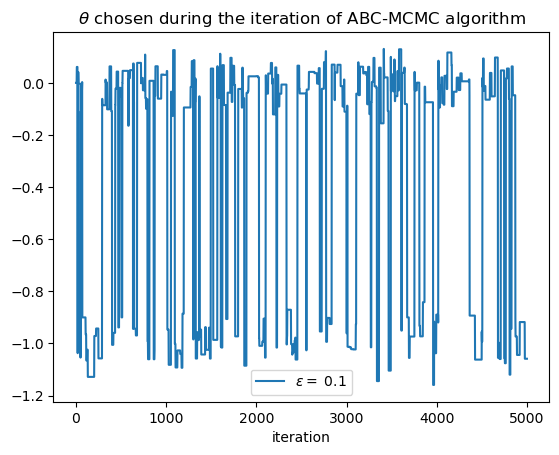

In [35]:
plt.figure()
plt.plot(theta, label = r'$\epsilon =$ %s' % e)
plt.legend()
plt.xlabel('iteration')
plt.title(r'$\theta$ chosen during the iteration of ABC-MCMC algorithm')

plt.show()

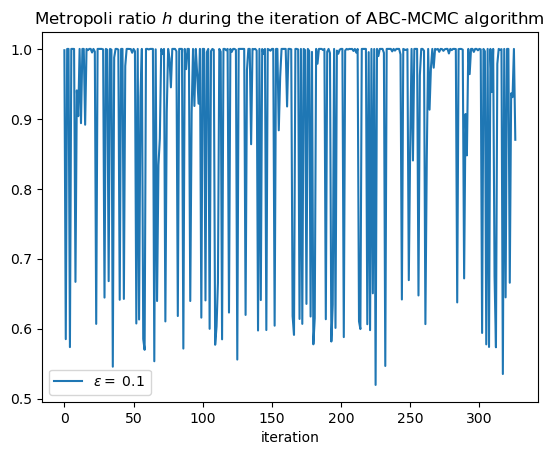

In [36]:
plt.figure()
plt.plot(metropoli_ratio_list, label = r'$\epsilon =$ %s' % e)
plt.legend()
plt.xlabel('iteration')
plt.title(r'Metropoli ratio $h$ during the iteration of ABC-MCMC algorithm')

plt.show()

We estimate now the number of iterations to have $N_{eff} \approx 500$.

In [37]:
### update (cont.)
b = 1000  # burn-in
mu_hat = theta[b:].mean()

k = 0
while k < N_max-1:
    c_hat.append(1/(N_max-k-1)*np.multiply(theta[b:N_max-k+1] - mu_hat, theta[b+k:] - mu_hat).sum())
    k = k + 1

In [38]:
### update (cont.)
for k, _ in enumerate(c_hat):
    if c_hat[2*k] - c_hat[2*k+1] < 0:
        M_eff = 2*k
        break
print(M_eff)

104


In [39]:
var_M_hat = c_hat[0] + 2*sum(c_hat[1:M_eff+1])
var_hat = c_hat[0] + 2*sum(c_hat[1:])

print('sigma^2^hat =', var_hat)
print('sigma^2^hat_M =', var_M_hat)

sigma^2^hat = 0.8643013465876511
sigma^2^hat_M = 8.84967314622196


In [40]:
N_max = math.ceil(N_eff*var_M_hat/c_hat[0])
print('N_max =', N_max)

N_max = 23921


Now let us plot as in basic MCMC the estimated posterior for different values of $\epsilon$.

In [41]:
### update (cont.)
x_values = np.linspace(-1.25, 0.5, 500)
f = true_mixture_distribution(x_values, M, a, var, var_1, sample_mean=0)
theta_list = []
metropoli_ratio_list = []

for e in eps:
    theta, metropoli_ratios = abc_mcmc(N_max, M, e, nu_squared, var, var_1, a)
    theta_list.append(theta)
    metropoli_ratio_list.append(metropoli_ratios)

acceptance count is: 9156 ; count of rho < epsilon is: 10486 ; rejection count is: 14765
acceptance rate: 0.3827599180636261
acceptance count is: 3358 ; count of rho < epsilon is: 3781 ; rejection count is: 20563
acceptance rate: 0.14037874670791356
acceptance count is: 1319 ; count of rho < epsilon is: 1454 ; rejection count is: 22602
acceptance rate: 0.055139835291166756
acceptance count is: 314 ; count of rho < epsilon is: 346 ; rejection count is: 23607
acceptance rate: 0.013126541532544627


/Users/michelelupini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michelelupini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michelelupini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/michelelupini/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

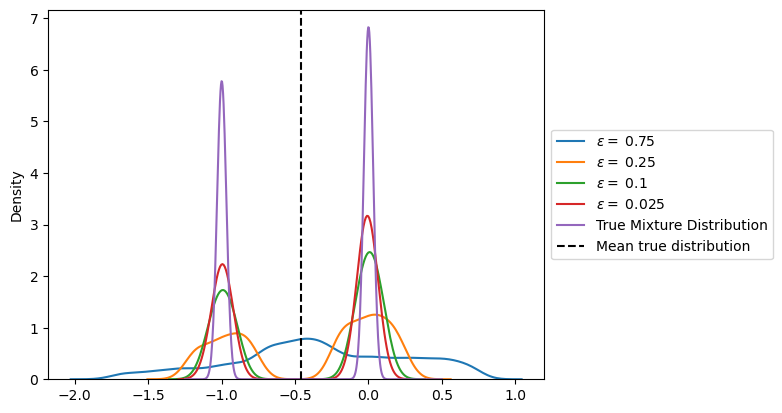

In [42]:
alpha =  1./( 1 + np.exp( a * (sample_mean - 0.5*a) * M / (M*var + var_1) ) )

plt.figure()

for i in (range(len(eps))):
    sns.kdeplot(theta_list[i], label=r'$\epsilon =$ %s' % eps[i])
    
plt.plot(x_values, f, label='True Mixture Distribution')
plt.axvline(x=0+(1-alpha)*var/(var+var_1/M)*(sample_mean-a), color='black', linestyle='--', label='Mean true distribution')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

We can look also at the evolution of the samples $\theta_i$ chosen by ABC-MCMC algorithm

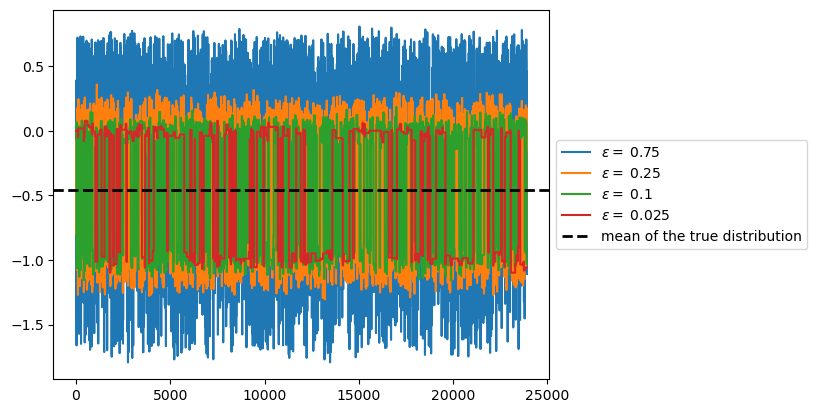

In [43]:
plt.figure()

for i in (range(len(eps))):
    plt.plot(theta_list[i], label=r'$\epsilon =$ %s' % eps[i])
    
plt.axhline(y=(1-alpha)*(sample_mean-a), color='black', linestyle='--', linewidth=2, label='mean of the true distribution')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

**Q**. How can we compare these distributions? Binning etc..??

In [19]:
def kl_divergence(p, q):
    """
    Calculate KL divergence between two probability distributions p and q.
    """
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# Point 4 - Calculate summary statistic

In [30]:
# Define parameters of pharmacokinetic model
K_e = 0.08
K_a = 1.5
Cl = 0.04
sigma = 0.2
D = 4

Let us use the Euler-Maruyama method to estimate $X(t)$.

In [31]:
def simulate_Xt_times(K_e, K_a, Cl, sigma):
    np.random.seed(42)
    dt = 0.05  # Time step
    T = 12  # Total time
    n = int(T / dt)+1  # Number of time steps
    D = 4

    t = np.arange(0, 12.05, 0.05)  # Vector of times

    X_t = np.zeros(n) # Recall that X_0 = 0
    for i in range(n - 1):
        X_t[i + 1] = X_t[i] + dt*( (D*K_a*K_e)/Cl * np.exp(-K_a*t[i+1]) - K_e*X_t[i] ) + sigma*np.sqrt(dt)*np.random.randn()
    
    times = [0.25, 0.5, 1, 2, 3.5, 5, 7, 9, 12]
    indices = np.where(np.isin(t, times))
    Data = X_t[indices]
    return Data

def simulate_Xt_full(K_e, K_a, Cl, sigma):
    np.random.seed(42)
    dt = 0.05  # Time step
    T = 12  # Total time
    n = int(T / dt)+1  # Number of time steps
    D = 4

    t = np.arange(0, 12.05, 0.05)  # Vector of times

    X_t = np.zeros(n) # Recall that X_0 = 0
    for i in range(n - 1):
        X_t[i + 1] = X_t[i] + dt*( (D*K_a*K_e)/Cl * np.exp(-K_a*t[i+1]) - K_e*X_t[i] ) + sigma*np.sqrt(dt)*np.random.randn()
    
    return X_t

In [32]:
X_t = simulate_Xt_full(K_e, K_a, Cl, sigma)

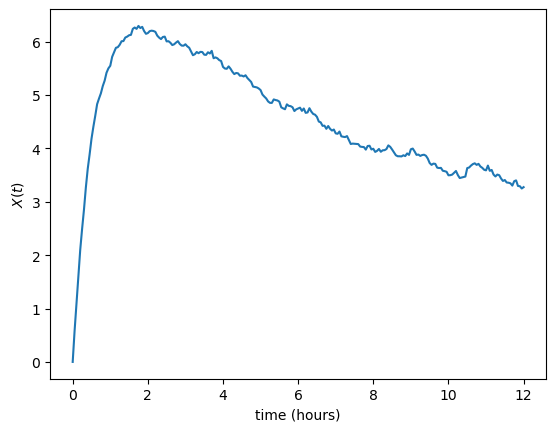

In [33]:
plt.figure()

plt.plot(t, X_t, label=r'$X(t)$')
plt.xlabel('time (hours)')
plt.ylabel(r'$X(t)$')

plt.show()

We fit now a Linear Regression.

In [34]:
xs = simulate_Xt_times(K_e, K_a, Cl, sigma)
print('data are:', xs)

data are: [2.49026964 4.17926941 5.54835907 6.16128545 5.75647863 5.09252414
 4.28144018 3.98492409 3.27435603]


In [7]:
n_data = 10000
X = np.zeros((n_data, len(times))) 
Y = np.zeros((n_data, 4)) #4 is the number of parameters of interest

for j in range(n_data):
    K_a = np.exp(np.random.normal(0.14, 0.4))
    K_e = np.exp(np.random.normal(-2.7, 0.6))
    Cl = np.exp(np.random.normal(-3, 0.8))
    sigma = np.exp(np.random.normal(-1.1, 0.3))
    
    theta = [K_e, K_a, Cl, sigma]
    Y[j,:] = theta
    
    X_t = np.zeros(n) # Recall that X_0 = 0
    for i in range(n - 1):
        X_t[i + 1] = X_t[i] + dt*( (D*K_a*K_e)/Cl * np.exp(-K_a*t[i+1]) - K_e*X_t[i] ) + sigma*np.sqrt(dt)*np.random.randn()
    X[j,:] = X_t[indices]

In [8]:
# Fit linear regression model
model = LinearRegression()
model.fit(X, Y)

# Get the estimated coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

print("Estimated Coefficients:", coefficients)
print("Intercept:", intercept)

Estimated Coefficients: [[-5.35901046e-03  1.89494342e-03  1.21921567e-03  5.03522923e-03
   3.43069134e-03 -4.02137048e-04 -2.14472414e-03 -1.97653409e-03
  -9.77701246e-03]
 [ 3.76824838e-01  3.80533583e-02 -8.55946412e-02 -8.18698791e-02
  -2.99583903e-02  2.41383688e-02  8.10956606e-04  2.10429886e-02
  -4.63201206e-04]
 [ 6.12356740e-03 -5.43412177e-03 -2.90499598e-03  4.17474557e-03
  -4.70242963e-04 -1.69465933e-03  1.20004899e-03 -3.45668114e-03
  -5.49048647e-03]
 [-1.73832732e-03 -1.28724739e-03  2.51357965e-03 -2.50753355e-05
   2.15653089e-03 -2.70033558e-03 -2.75800667e-03  3.15823152e-03
  -4.45288910e-04]]
Intercept: [0.07411369 1.24422406 0.10042788 0.34715371]


Finally, we can calculate the summary statistic $S(\mathcal{D})$ using the first data we generated. 

$S(\mathcal{D}) = \mathbb{E}[\theta| \mathcal{D}]= \begin{bmatrix} \theta_1 \\ \theta_2 \\ \theta_3 \\ \theta_4 \end{bmatrix} = \begin{bmatrix} \beta_0^{(1)} \\ \beta_0^{(2)} \\ \beta_0^{(3)} \\ \beta_0^{(4)} \end{bmatrix} + \begin{bmatrix} \beta_1^{(1)} \ ... \ \beta_9^{(1)} \\ \beta_1^{(2)} \ ... \ \beta_9^{(2)} \\ \beta_1^{(3)} \ ... \ \beta_9^{(3)} \\ \beta_1^{(4)} \ ... \ \beta_9^{(4)} \end{bmatrix} \cdot \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_9 \end{bmatrix}$

In [9]:
S_D = intercept + coefficients@xs
print("Summary statistic is", S_D)

Summary statistic is [0.07510447 1.39860173 0.06461888 0.34921833]


# Point 5 - ABC_MCMC on Pmodel and estimate of the posterior mean $\theta^{PM}$

In [56]:
def new_discrepancy_metric(D_star, D_0, S_D, intercept, coefficients, theta_0):
    S_D_star = intercept + coefficients@D_star
    S_D_0 = intercept + coefficients@D_0
    
    diff = S_D_star - S_D
    diff_0 = S_D_0 - S_D
    
    metric = 0
    
    for i in range(len(diff)):
        metric += diff[i]**2/(theta_0[i])**2
        
    return metric

Let us now generate $\mathcal{D}_0$.

In [53]:
# Define parameters of pharmacokinetic model
K_e = 0.07
K_a = 1.15
Cl = 0.05
sigma = 0.33

D = 4
np.random.seed(42)

D_0 = simulate_Xt_times(K_e, K_a, Cl, sigma)
print("Data at step zero are:", D_0)

Data at step zero are: [1.51758543 2.66344481 3.31208867 3.83354734 3.83001661 3.44833911
 2.91151882 3.09092926 2.74002271]


In [59]:
def abc_mcmc_pharma(N_max, M, eps, vu_matrix, var, var_1, a, S_D, intercept, coefficients):
    
    theta = np.zeros((N_max + 1,4))
    theta[0,:] = [0.07, 1.15, 0.05, 0.33]
    D_0 = simulate_Xt_times(0.07, 1.15, 0.05, 0.33)
    
    prior_K_e = st.lognorm(s=0.6, scale=np.exp(-2.7))
    prior_K_a = st.lognorm(s=0.4, scale=np.exp(0.14))
    prior_Cl = st.lognorm(s=0.8, scale=np.exp(-3))
    prior_sigma = st.lognorm(s=0.3, scale=np.exp(-1.1))
    
    acceptance_count = 0
    rejection_count = 0
    entered = 0
    i = 0
    metropoli_ratio_list = []
    
    while i < N_max:
        # sample candidate parameters from a proposal transition density q(theta_i, )
        # random walk proposal q(theta, ) = N(theta,nu_squared)
        q_i = st.multivariate_normal(mean=theta[i,:], cov=vu_matrix)
        theta_star = q_i.rvs()
    
        # generate data from the underlying model given theta_star
        K_e = theta_star[0]
        K_a = theta_star[1]
        Cl = theta_star[2]
        sigma = theta_star[3]
        
        D_star = simulate_Xt_times(K_e, K_a, Cl, sigma)
    
        if new_discrepancy_metric(D_star, D_0, S_D, intercept, coefficients, theta_0=theta[0,:]) < eps:
            
            q_star = st.multivariate_normal(mean=theta_star, cov=vu_matrix)
            
            # comp = pi_rv.pdf(theta_star)*q_star.pdf(theta[i])/( pi_rv.pdf(theta[i])*q_i.pdf(theta_star) )
            comp = 1
            
            metropoli_ratio_list.append(min(1.,comp))
            entered += 1
            
            if st.uniform.rvs() < comp:
                theta[i+1,:] = theta_star
                acceptance_count += 1 
            else:
                theta[i+1,:] = theta[i,:]
                rejection_count += 1
        else:
            theta[i+1,:] = theta[i,:]
            rejection_count += 1
            
        i += 1
    
    print("acceptance count is:", acceptance_count, "; count of rho < epsilon is:", entered, "; rejection count is:", rejection_count) ## DEBUG
    #if acceptance_count == 500:
    #    print('effective sample size achieved')
    print('acceptance rate:', acceptance_count/(acceptance_count+rejection_count))
    return theta, metropoli_ratio_list

In [60]:
N_max = 10000
M = 100
var_1 = 0.1
var = 3
a = 1
sample_mean = 0  # assumed to be exactly =0
eps = 1
vu_matrix = np.eye(4)

theta = abc_mcmc_pharma(N_max, M, eps, vu_matrix, var, var_1, a, S_D, intercept, coefficients)

acceptance count is: 0 ; count of rho < epsilon is: 0 ; rejection count is: 10000
acceptance rate: 0.0


In [57]:
new_discrepancy_metric(D_0, D_0, S_D, intercept, coefficients, [0.07, 1.15, 0.05, 0.33])

0.03527715170410623